<a href="https://colab.research.google.com/github/asifsohailmd/SemEval/blob/main/NLP_Project_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving semeval_test.txt to semeval_test.txt
Saving semeval_train.txt to semeval_train.txt
User uploaded file "semeval_test.txt" with length 418243 bytes
User uploaded file "semeval_train.txt" with length 1235657 bytes


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import spacy
nlp = spacy.load("en_core_web_sm")
from IPython.core.display import display, HTML
from spacy import displacy
import networkx as nx

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem.porter import *
nltk.download('wordnet')

from sklearn.feature_extraction import DictVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# df = pd.read_csv('EntityRelation.csv')
# features = pd.read_csv('Features.csv')
# features = pd.read_csv('semeval_Features.csv')

**Task 1**


In [3]:
def CorpusReader(filename):
  f = open(filename,"r")
  data = f.readlines()

  relations = []
  sentences = []
  e1 = []
  e2 = []

  for i in range(len(data)):
    if i%4 == 0:
      sentences.append(data[i].split('\t')[1].strip('\n\t\s '))
      e1.append(str(re.findall(r'<e.>.*?</e.>', data[i])[0][4:-5].strip()))
      e2.append(str(re.findall(r'<e.>.*?</e.>', data[i])[1][4:-5].strip()))
    elif i%4 == 1:
      relations.append(data[i][:-1])
  
  df = pd.DataFrame()
  # features = pd.DataFrame()
  df['Sentence'] = sentences
  df['Relation_Direction'] = relations
  df['Relation'] = df['Relation_Direction'].apply(lambda x: x if x == 'Other' else x[:-7])
  df['Direction'] = df['Relation_Direction'].apply(lambda x: 'ND' if x =='Other' else x[-7:])
  df['Entity1'] = e1
  df['Entity2'] = e2
  df['Sentence'].replace(regex=['<e1>', '</e1>', '<e2>', '</e2>'], value=' ', inplace=True)
  df['Sentence'] = df['Sentence'].str.strip('" ')
  df['Sentence'] = df['Sentence'].apply(lambda x: re.sub(' +', ' ', x))
  return df

In [4]:
trainDF = CorpusReader("semeval_train.txt")
testDF = CorpusReader("semeval_test.txt")

Total number of uniqie relations in train data: 19


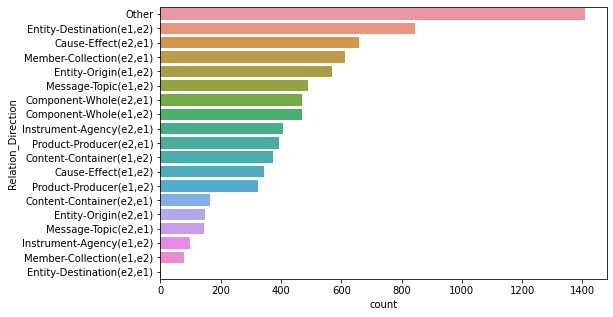

In [5]:
print("Total number of uniqie relations in train data:", len(trainDF['Relation_Direction'].unique()))
plt.figure(figsize=(8,5))
plot = sns.countplot(data=trainDF, y='Relation_Direction', order=trainDF.Relation_Direction.value_counts().index)

Total number of uniqie relations in train data without direction: 10


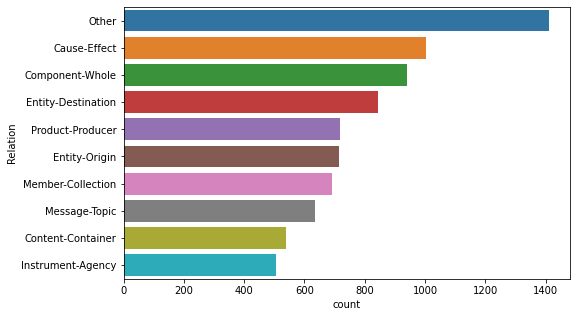

In [6]:
print("Total number of uniqie relations in train data without direction:", len(trainDF['Relation'].unique()))
plt.figure(figsize=(8,5))
sns.countplot(data=trainDF, y='Relation', order=trainDF.Relation.value_counts().index)

In [7]:
trainDF.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2
0,The system as described above has its greatest...,"Component-Whole(e2,e1)",Component-Whole,"(e2,e1)",configuration,elements
1,The child was carefully wrapped and bound into...,Other,Other,ND,child,cradle
2,The author of a keygen uses a disassembler to ...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",author,disassembler
3,A misty ridge uprises from the surge .,Other,Other,ND,ridge,surge
4,The student association is the voice of the un...,"Member-Collection(e1,e2)",Member-Collection,"(e1,e2)",student,association


In [8]:
testDF.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2
0,The most common audits were about waste and re...,"Message-Topic(e1,e2)",Message-Topic,"(e1,e2)",audits,waste
1,The company fabricates plastic chairs .,"Product-Producer(e2,e1)",Product-Producer,"(e2,e1)",company,chairs
2,The school master teaches the lesson with a st...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",master,stick
3,The suspect dumped the dead body into a local ...,"Entity-Destination(e1,e2)",Entity-Destination,"(e1,e2)",body,reservoir
4,Avian influenza is an infectious disease of bi...,"Cause-Effect(e2,e1)",Cause-Effect,"(e2,e1)",influenza,virus


In [ ]:
# df.to_csv('EntityRelation.csv', index=False)

**Task 2**

In [9]:
# Tokens
def get_tokens(sentence):
  return [word.text for word in nlp(sentence)]

In [10]:
# Lemmas
def get_lemmas(sentence):
  return [word.lemma_ for word in nlp(sentence)]

In [11]:
# Penn Treebank POS Tags
def get_POS_tags(sentence):
  return [word.tag_ for word in nlp(sentence)]

Dependency Parse Tree Features

In [12]:
# Dependency Parse Tags for each word and its head
def get_DEP_tags(sentence):
  return [word.dep_ for word in nlp(sentence)]

# Dependency Parse POS tag for head of each word
def get_DEP_Parent_POS(sentence):
  return [word.head.pos_ for word in nlp(sentence)]

In [13]:
def find_sub_list(l, sublist):
  sl_length = len(sublist)
  if sl_length == 0:
    return [-1, -1]
  for ind in (i for i, e in enumerate(l) if e == sublist[0]):
    if l[ind: ind+sl_length] == sublist:
      return [ind, ind + sl_length - 1]

In [14]:
# Shortest Dependency Path
def dep(sentence, entity1, entity2, direction):
  shortest_dep_path = []
  length = 0
  tokens = get_tokens(sentence)

  entity1_tokens = get_tokens(entity1)
  entity2_tokens = get_tokens(entity2)
  if len(entity1_tokens) == 0 or len(entity2_tokens) == 0:
    return pd.Series((shortest_dep_path, length))

  for chunk in nlp(entity1).noun_chunks:
    entity1 = chunk.root.head.text

  for chunk in nlp(entity2).noun_chunks:
    entity2 = chunk.root.head.text

  edges = []
  data = []
  graph = nx.Graph(edges)
  for token in nlp(sentence):
    data.append([token.head.text, token.text, token.dep_])
    for child in token.children:
      graph.add_edge(token.text, child.text)

  # To plot the graph
  # nx.draw(graph, with_labels=True)
  
  if graph.has_node(entity1) and graph.has_node(entity2) and nx.has_path(graph, entity1, entity2):
    if direction == '(e2,e1)':
      path = nx.shortest_path(graph, source=entity2, target=entity1)
    else:
      path = nx.shortest_path(graph, source=entity1, target=entity2)
    length = nx.shortest_path_length(graph, entity1, entity2)
  else:
    path = []

  for i in range(len(path)-1):
    for j in data:
      if j[0].lower() == path[i].lower() and j[1].lower() == path[i+1].lower():
        shortest_dep_path.append(j[2])
      elif j[0].lower() == path[i+1].lower() and j[1].lower() == path[i].lower():
        shortest_dep_path.append(j[2])
  return pd.Series((shortest_dep_path, length))

In [18]:
# Shortest Depencey Path Display
i = 1
print(dep(trainDF.iloc[i,0], trainDF.iloc[i,4], trainDF.iloc[i,5], trainDF.iloc[i,3]))
print(trainDF.iloc[i,4])
print(trainDF.iloc[i,5])
print(trainDF.iloc[i,3])

options = {"collapse_phrases" : False}
html = displacy.render(nlp(trainDF.iloc[i,0]), style="dep")
display(HTML(html))

0    [nsubjpass, conj, prep, pobj]
1                                4
dtype: object
child
cradle
ND


WordNet

In [19]:
def get_entity_POS(sentence, entity):
  entity_tokens = get_tokens(entity)
  sentence_tokens = get_tokens(sentence)

  if len(entity_tokens) == 0:
    return 'X'

  e1_start, e1_end = find_sub_list(sentence_tokens, entity_tokens)

  pos = get_POS_tags(sentence)
  if e1_start == e1_end:
    return pos[e1_start]
  else:
    for chunk in nlp(entity).noun_chunks:
      return pos[sentence_tokens.index(chunk.root.head.text)]
  return 'X'

In [21]:
def get_wordnet_pos(entity_pos):
  pos = None
  if entity_pos.startswith('J'):
    pos = wordnet.ADJ
  elif entity_pos.startswith('N'):
    pos = wordnet.NOUN
  elif entity_pos.startswith('R'):
    pos = wordnet.ADV
  elif entity_pos.startswith('V'):
    pos = wordnet.VERB
  return pos

In [20]:
# hypernymns, hyponyms, meronyms, holonyms and synset similarities
def get_synsets(entity, entity_pos):
  entity = str(entity)
  
  pos = get_wordnet_pos(entity_pos)
  hype = ['O']
  hypo = ['O']
  mero = ['O']
  holo = ['O']

  #part / member / substance
  syn = wordnet.synsets(entity, pos=pos)
  if len(syn) > 0:
    hype = [x.name().split('.')[0] for x in syn[0].hypernyms()]
    hypo = [x.name().split('.')[0] for x in syn[0].hyponyms()]
    mero = [x.name().split('.')[0] for x in syn[0].part_meronyms()]
    holo = [x.name().split('.')[0] for x in syn[0].member_holonyms()]

  hype = ['O'] if len(hype) == 0 else hype
  hypo = ['O'] if len(hypo) == 0 else hypo
  mero = ['O'] if len(mero) == 0 else mero
  holo = ['O'] if len(holo) == 0 else holo

  return pd.Series((hype, hypo, mero, holo))

In [22]:
# Path similarity
def get_similarities(entity1, entity2, entity1_pos, entity2_pos):
  pos1 = get_wordnet_pos(entity1)
  pos2 = get_wordnet_pos(entity2)

  synsets1 = wordnet.synsets(entity1, pos=pos1)
  synsets2 = wordnet.synsets(entity2, pos=pos2)

  if len(synsets1) > 0 and len(synsets2) > 0:
    similarity = synsets1[0].path_similarity(synsets2[0])
  else:
    similarity = 0.0
  return similarity if similarity else 0.0

In [24]:
# NER using spaCy
def NER(sentence, entity1, entity2):
  doc = nlp(sentence)
  e1 = 'NONE'
  e2 = 'NONE'

  for chunk in nlp(entity1).noun_chunks:
    entity1 = chunk.root.head.text

  for chunk in nlp(entity2).noun_chunks:
    entity2 = chunk.root.head.text
    
  for ent in doc.ents:
    if entity1 in ent.text:
      e1 = ent.label_
    elif entity2 in ent.text:
      e2 = ent.label_
  return pd.Series((e1, e2))

In [25]:
def features(DataFrame):
  DataFrame['Entity1_POS'] = DataFrame.apply(lambda x: get_entity_POS(x.Sentence, x.Entity1), axis=1)
  DataFrame['Entity2_POS'] = DataFrame.apply(lambda x: get_entity_POS(x.Sentence, x.Entity2), axis=1)
  DataFrame['Tokens'] = DataFrame.apply(lambda x: get_tokens(x.Sentence), axis=1)
  DataFrame['Lemmas'] = DataFrame.apply(lambda x: get_lemmas(x.Sentence), axis=1)
  DataFrame['POS Tags'] = DataFrame.apply(lambda x: get_POS_tags(x.Sentence), axis=1)
  DataFrame['DEP Tags'] = DataFrame.apply(lambda x: get_DEP_tags(x.Sentence), axis=1)
  DataFrame['DEP Parent POS'] = DataFrame.apply(lambda x: get_DEP_Parent_POS(x.Sentence), axis=1)
  DataFrame[['ShortestPath', 'ShortestPathLength']] = DataFrame.apply(lambda x: dep(x.Sentence, x.Entity1, x.Entity2, x.Direction), axis=1)
  DataFrame[['NE1', 'NE2']] = DataFrame.apply(lambda x: NER(x.Sentence, x.Entity1, x.Entity2), axis=1)
  DataFrame[['E1_hype', 'E1_hypo', 'E1_mero', 'E1_holo']] = DataFrame.apply(lambda x: get_synsets(x.Entity1, x.Entity1_POS), axis=1)
  DataFrame[['E2_hype', 'E2_hypo', 'E2_mero', 'E2_holo']] = DataFrame.apply(lambda x: get_synsets(x.Entity2, x.Entity2_POS), axis=1)
  DataFrame['PathSimilarity'] = DataFrame.apply(lambda x: get_similarities(x.Entity1, x.Entity2, x.Entity1_POS, x.Entity2_POS), axis=1)
  return DataFrame

In [26]:
trainDF = features(trainDF)
testDF = features(testDF)

In [ ]:
trainDF.head()

In [ ]:
testDF.head()

Other features

In [31]:
# Stem of entities
def get_stems(entity):
  stemmer = PorterStemmer()
  return stemmer.stem(entity)

In [32]:
# Prefixes of length 5 between the entities, word before e1, word after e2, POS sequence between entities, word count between entities
def get_prefixes(sentence, entity1, entity2):
  entity1 = get_tokens(entity1)
  entity2 = get_tokens(entity2)
  tokens = get_tokens(sentence)

  e1Index = find_sub_list(tokens, entity1)
  e2Index = find_sub_list(tokens, entity2)

  if e1Index[0] != -1:
    before_e1 = tokens[e1Index[0] - 1] if e1Index[0] != 0 else 'O'
  if e2Index[0] != -1:
    after_e2 = tokens[e2Index[-1] + 1] if e2Index[-1] != len(tokens)-1 else 'O'

  if e1Index[0] == -1 or e2Index[0] == -1:
    return pd.Series([], before_e1, after_e2, 'O', 0)

  words_bet_nominals = tokens[e1Index[-1] + 1: e2Index[0]]
  sentence_bet_nominals = ' '.join(word for word in words_bet_nominals)
  prefix_list = [i[:5] for i in words_bet_nominals]
  # prefix_list = get_stems(sentence_bet_nominals)

  len_bet_nominals = len(words_bet_nominals)

  pos_bet_nominals = get_POS_tags(sentence_bet_nominals)
  pos_bet_nominals = '_'.join(i[0] for i in pos_bet_nominals)

  return pd.Series((prefix_list, before_e1, after_e2, pos_bet_nominals, len_bet_nominals))

In [33]:
# Gloss
def gloss(entity1, entity2, entity1_pos, entity2_pos):
  pos1 = get_wordnet_pos(entity1_pos)
  pos2 = get_wordnet_pos(entity2_pos)

  syn1 = wordnet.synsets(entity1, pos=pos1)
  syn2 = wordnet.synsets(entity2, pos=pos2)

  res = 0
  if len(syn1) == 0 or len(syn2) == 0:
    return 0
  for i in syn1:
    for j in syn2:
      syn1_def = i.definition()
      syn2_def = j.definition()
      if j.name().split('.')[0] in syn1_def:
        res = 1
      elif i.name().split('.')[0] in syn2_def:
        res = 1
  return res

In [39]:
def other_features(DataFrame):
  DataFrame['E1_Stems'] = DataFrame.apply(lambda x: get_stems(x.Entity1), axis=1)
  DataFrame['E2_Stems'] = DataFrame.apply(lambda x: get_stems(x.Entity2), axis=1)
  DataFrame[['prefixes', 'before_E1', 'after_E2', 'POS_bet_Noms', 'wordCount_Bet_Noms']] = DataFrame.apply(lambda x: get_prefixes(x.Sentence, x.Entity1, x.Entity2), axis=1)
  DataFrame['Gloss'] = DataFrame.apply(lambda x: gloss(x.Entity1, x.Entity2, x.Entity1_POS, x.Entity2_POS), axis=1)
  return DataFrame

In [40]:
trainDF = other_features(trainDF)
testDF = other_features(testDF)

In [44]:
trainDF.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2,Entity1_POS,Entity2_POS,Tokens,Lemmas,POS Tags,DEP Tags,DEP Parent POS,ShortestPath,ShortestPathLength,NE1,NE2,E1_hype,E1_hypo,E1_mero,E1_holo,E2_hype,E2_hypo,E2_mero,E2_holo,PathSimilarity,E1_Stems,E2_Stems,prefixes,before_E1,after_E2,POS_bet_Noms,wordCount_Bet_Noms,Gloss
0,The system as described above has its greatest...,"Component-Whole(e2,e1)",Component-Whole,"(e2,e1)",configuration,elements,NN,NNS,"[The, system, as, described, above, has, its, ...","[the, system, as, describe, above, have, -PRON...","[DT, NN, IN, VBN, IN, VBZ, PRP$, JJS, NN, IN, ...","[det, nsubj, mark, acl, advmod, ROOT, poss, am...","[NOUN, AUX, VERB, NOUN, VERB, AUX, NOUN, NOUN,...","[pobj, prep]",2,NONE,NONE,[design],"[redundancy, topology, unitization]",[O],[O],[weather],[O],[O],[O],0.062500,configur,element,"[of, anten]",arrayed,.,I_N,2,1
1,The child was carefully wrapped and bound into...,Other,Other,ND,child,cradle,NN,NN,"[The, child, was, carefully, wrapped, and, bou...","[the, child, be, carefully, wrap, and, bind, i...","[DT, NN, VBD, RB, VBN, CC, VBN, IN, DT, NN, IN...","[det, nsubjpass, auxpass, advmod, ROOT, cc, co...","[NOUN, VERB, VERB, VERB, VERB, VERB, VERB, VER...","[nsubjpass, conj, prep, pobj]",4,NONE,NONE,[juvenile],"[bairn, buster, changeling, child_prodigy, fos...",[child's_body],[O],[baby_bed],[O],[rocker],[O],0.083333,child,cradl,"[was, caref, wrapp, and, bound, into, the]",The,by,V_R_V_C_V_I_D,7,0
2,The author of a keygen uses a disassembler to ...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",author,disassembler,NN,NN,"[The, author, of, a, keygen, uses, a, disassem...","[the, author, of, a, keygen, use, a, disassemb...","[DT, NN, IN, DT, NN, VBZ, DT, NN, TO, VB, IN, ...","[det, nsubj, prep, det, pobj, ROOT, det, dobj,...","[NOUN, VERB, NOUN, NOUN, ADP, VERB, NOUN, VERB...","[dobj, nsubj]",2,NONE,NONE,[communicator],"[abstractor, alliterator, authoress, biographe...",[O],[O],[O],[O],[O],[O],0.000000,author,disassembl,"[of, a, keyge, uses, a]",The,to,I_D_N_V_D,5,0
3,A misty ridge uprises from the surge .,Other,Other,ND,ridge,surge,NN,NN,"[A, misty, ridge, uprises, from, the, surge, .]","[a, misty, ridge, uprise, from, the, surge, .]","[DT, JJ, NN, VBZ, IN, DT, NN, .]","[det, amod, compound, ROOT, prep, det, pobj, p...","[VERB, NOUN, VERB, VERB, VERB, NOUN, ADP, VERB]","[compound, prep, pobj]",3,NONE,NONE,[natural_elevation],"[bank, bar, dune, esker, ledge, reef, ripple_m...",[O],[O],[flow],"[debris_surge, onrush]",[O],[O],0.071429,ridg,surg,"[upris, from, the]",misty,.,N_I_D,3,0
4,The student association is the voice of the un...,"Member-Collection(e1,e2)",Member-Collection,"(e1,e2)",student,association,NN,NN,"[The, student, association, is, the, voice, of...","[the, student, association, be, the, voice, of...","[DT, NN, NN, VBZ, DT, NN, IN, DT, NNP, NN, NN,...","[det, compound, nsubj, ROOT, det, attr, prep, ...","[NOUN, NOUN, AUX, AUX, NOUN, AUX, NOUN, NOUN, ...",[compound],1,NONE,NONE,[enrollee],"[art_student, auditor, catechumen, collegian, ...",[O],[teacher-student_relation],[organization],"[american_baptist_convention, american_legion,...",[O],[O],0.090909,student,associ,[],The,is,,0,0


In [43]:
# trainDF.isnull().values.any()
# testDF.isnull().values.any()

False

In [46]:
# trainDF.to_csv('trainDF.csv', index=False)
# testDF.to_csv('testDF.csv', index=False)

In [ ]:
# Assumption: entities are single token
def vectorial(sentence, entity):
  entity1 = re.split('\s|\-|\'', entity)
  tokens = get_tokens(sentence)

  start_index, end_index = find_sub_list(entity1, tokens)
  print(start_index, end_index)

  e1_start = start_index-3
  e1_end = end_index+3

  print(e1_start, e1_end)
  count = -(abs(end_index) - abs(start_index))

  while(count <= 6):
    if e1_start >= 0 and e1_start < len(tokens) and (e1_start < start_index or e1_start > end_index):
      print(tokens[e1_start])
    e1_start += 1
    count += 1


In [ ]:
vectorial(df.iloc[1,0], df.iloc[1,3])

0 2
-3 5
is
a
public


**Task 3**

Test Data

In [ ]:
f = open("semeval_test.txt","r")
data = f.readlines()

relations = []
sentences = []
e1 = []
e2 = []

for i in range(len(data)):
  if i%4 == 0:
    sentences.append(data[i].split('\t')[1].strip('\n\t\s '))
    e1.append(re.findall(r'<e.>.*?</e.>', data[i])[0][4:-5].strip())
    e2.append(re.findall(r'<e.>.*?</e.>', data[i])[1][4:-5].strip())
  elif i%4 == 1:
    relations.append(data[i][:-1])

test_df = pd.DataFrame()
test_df['Sentences'] = sentences
test_df['Relations'] = relations
test_df['Direction'] = test_df['Relations'].apply(lambda x: 'ND' if x =='no_relation' else x[-7:])
test_df['Entity1'] = e1
test_df['Entity2'] = e2
test_df.replace(regex=['<e1> ', '</e1> ', '<e2> ', ' </e2>'], value=' ', inplace=True)
test_df['Sentences'] = test_df['Sentences'].str.strip('" ')
test_df['Sentences'] = test_df['Sentences'].apply(lambda x: re.sub(' +', ' ', x))
test_df['Relations'] = test_df['Relations'].apply(lambda x: x if x == 'Other' else x[:-7])
test_df['Labelled_Relations'] = le.transform(test_df['Relations'])

In [ ]:
test_df.head()

,Sentences,Relations,Direction,Entity1,Entity2,Labelled_Relations
0,The most common <e1>audits were about <e2>wast...,Message-Topic,"(e1,e2)",audits,waste,7
1,The <e1>company fabricates plastic <e2>chairs<...,Product-Producer,"(e2,e1)",company,chairs,9
2,The school <e1>master teaches the lesson with ...,Instrument-Agency,"(e2,e1)",master,stick,5
3,The suspect dumped the dead <e1>body into a lo...,Entity-Destination,"(e1,e2)",body,reservoir,3
4,Avian <e1>influenza is an infectious disease o...,Cause-Effect,"(e2,e1)",influenza,virus,0


Dict Vectorizer

In [ ]:
features.columns

Index(['Relations', 'Direction', 'Entity1', 'Entity2', 'Tokens', 'Lemmas',
       'POS Tags', 'DEP Tags', 'DEP Parent POS', 'ShortestPath',
       'ShortestPathLength', 'NE1', 'NE2', 'Entity1_POS', 'Entity2_POS',
       'E1_hype', 'E1_hypo', 'E1_mero', 'E1_holo', 'E2_hype', 'E2_hypo',
       'E2_mero', 'E2_holo', 'PathSimilarity', 'E1_Stems', 'E2_Stems',
       'prefixes', 'before_E1', 'after_E2', 'POS_bet_Noms',
       'wordCount_Bet_Noms', 'Gloss'],
      dtype='object')

In [ ]:
# features_dict = features.T.to_dict().values()

In [ ]:
features_dict = features[['ShortestPath', 'ShortestPathLength', 'Entity1_POS', 'Entity2_POS']].to_dict('records')

In [ ]:
features['Relations'].value_counts()

Other                 1410
Cause-Effect          1003
Component-Whole        941
Entity-Destination     845
Product-Producer       717
Entity-Origin          716
Member-Collection      690
Message-Topic          634
Content-Container      540
Instrument-Agency      504
Name: Relations, dtype: int64

In [ ]:
features['prefixes'].isnull().values.any()

False

In [ ]:
v = DictVectorizer()
featuresVec = v.fit_transform(features_dict).toarray()
inputDF = pd.DataFrame(featuresVec)
inputDF['Relations'] = features['Relations']

In [ ]:
inputDF.isnull().values.any()

False

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(inputDF['Relations'])
inputDF['Relations'] = le.transform(inputDF['Relations'])

In [ ]:
inputDF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,Relations
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6


Model

In [ ]:
X = inputDF.iloc[:,:-1]
y = inputDF.iloc[:,-1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2400 points : 1443


In [ ]:
y_pred = clf.predict(X)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.434375